In [12]:
import keras
import numpy as np
# import cv2
import matplotlib.pyplot as plt
from time import time
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.models import load_model


keras.__version__

'2.3.1'

In [13]:
# inception = InceptionV3(weights='full_retina_model.h5')
from keras.metrics import top_k_categorical_accuracy 
def top_2_accuracy(in_gt, in_pred): 
    return top_k_categorical_accuracy(in_gt, in_pred, k=2) 
# model.compile("adam", loss='categorical_crossentropy', metrics = ['categorical_accuracy', top_2_accuracy])
model = load_model('densenet_best_kappa.h5', custom_objects={'top_2_accuracy': top_2_accuracy})

In [3]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [3]:
IMG_SIZE = (300, 300, 3)
inp = Input(IMG_SIZE)
layer_outputs = [layer.get_output_at(-1) for layer in model.layers[:50]]
test_image = 'sample/16_left.jpeg'

img = image.load_img(test_image, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [5]:
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

In [6]:
layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'activation_9']
activ_list = [activations[1], activations[4], activations[5], activations[6], activations[7], activations[40]]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/site-packages/matplotlib/tight_bbox.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/usr/local/lib/python3.7/site-packages/matplotlib/tight_bbox.py:69: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/usr/local/lib/python3.7/site-packages/matplotlib/patches.py:745: RuntimeWarning: invalid value encountered in double_scalars
  self._y1 = self._y0 + self._height
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

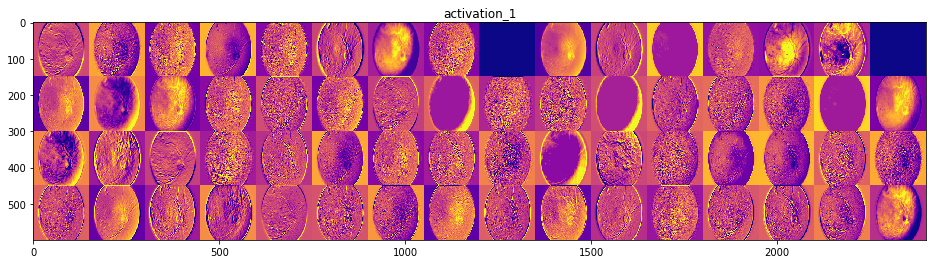

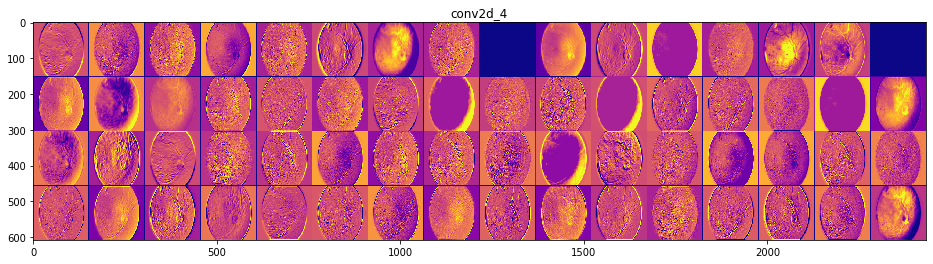

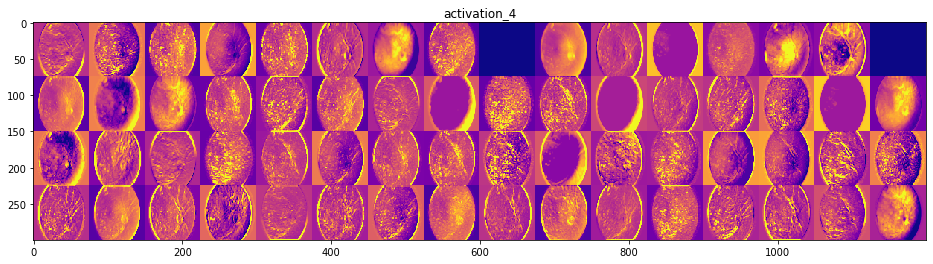

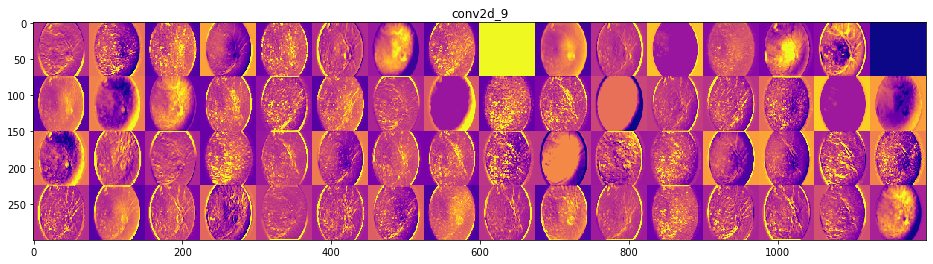

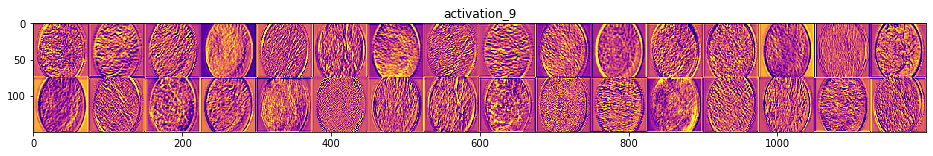

In [7]:

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activ_list):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')
    plt.savefig(layer_name+"_grid.jpg", bbox_inches='tight')

In [5]:
#what convnets learn

img_path = 'sample/16_left.jpeg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=IMG_SIZE)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 300, 300, 3)


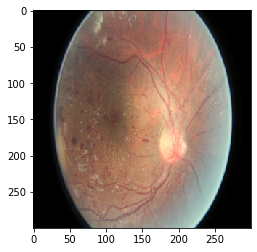

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

In [7]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[1:]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# layer_outputs = [layer.get_output_at(0) for layer in model.layers[:50]]

In [8]:
activations = activation_model.predict(img_tensor)

In [9]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 306, 306, 3)


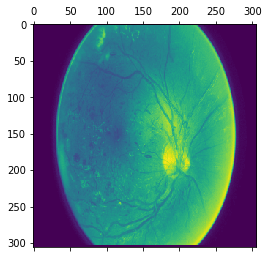

In [10]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

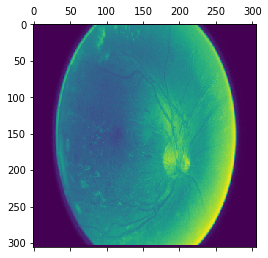

In [11]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
plt.show()

In [ ]:
import keras
import cv2
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[1:]:
    layer_names.append(layer.name)

print (len(layer_names))

images_per_row = 16

range_s = 0
range_e = 450
lidx = 0
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    lidx += 1
    if not (range_s<=lidx and lidx<=range_e):
        continue
    
    print ('processing', lidx)
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
#     outfilename = 'dense_layers/'+str(lidx)+'_'+layer_name
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(str(lidx)+'_'+layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    try:
        plt.savefig('dense_layers/'+str(lidx)+'_'+layer_name)
    except:
        pass
    
plt.show()

431
processing 1
processing 2


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in subtract


processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


processing 22
processing 23
processing 24
processing 25
processing 26
processing 27
processing 28
processing 29
processing 30
processing 31
processing 32
processing 33
processing 34
processing 35
processing 36
processing 37
processing 38
processing 39
processing 40
processing 41
processing 42
processing 43
processing 44
processing 45
processing 46
processing 47
processing 48
processing 49
processing 50
processing 51
processing 52
processing 53
processing 54
processing 55
processing 56
processing 57
processing 58
processing 59
processing 60
processing 61
processing 62
processing 63
processing 64
processing 65
processing 66
processing 67
processing 68
processing 69
processing 70
processing 71
processing 72
processing 73
processing 74
processing 75
processing 76
processing 77
processing 78
processing 79
processing 80
processing 81
processing 82
processing 83
processing 84
processing 85
processing 86
processing 87
processing 88
processing 89
processing 90
processing 91
processing 92
proces

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


processing 104
processing 105
processing 106
processing 107
processing 108
processing 109
processing 110
processing 111
processing 112
processing 113
processing 114
processing 115
processing 116
processing 117
processing 118
processing 119
processing 120
processing 121
processing 122
processing 123
processing 124
processing 125
processing 126
processing 127
processing 128
processing 129
processing 130
processing 131
processing 132
processing 133
processing 134
processing 135
processing 136
processing 137
processing 138
processing 139
processing 140
processing 141
processing 142
processing 143
processing 144
processing 145
processing 146
processing 147
processing 148
processing 149
processing 150
processing 151
processing 152
processing 153
processing 154
processing 155
processing 156
processing 157
processing 158
processing 159
processing 160
processing 161
processing 162
processing 163
processing 164
processing 165
processing 166
processing 167
processing 168
processing 169
processing

In [15]:
#Visualizing CNNs using deconvolutions

import argparse
import numpy as np
import sys
import time
from PIL import Image
from keras.layers import (
        Input,
        InputLayer,
        Flatten,
        Activation,
        Dense)
from keras.layers.convolutional import (
        Convolution2D,
        MaxPooling2D)
from keras.activations import *
from keras.models import Model
import keras.backend as K


class DInput(object):
    '''
    A class to define forward and backward operation on Input
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Input layer, whose configuration 
                   will be used to initiate DInput(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
    
    # input and output of Input layer are the same
    def up(self, data):
        '''
        function to operate input in forward pass, the input and output
        are the same
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            data
        '''
        self.up_data = data
        return self.up_data
    
    def down(self, data):
        '''
        function to operate input in backward pass, the input and output
        are the same
        # Arguments
            data: Data to be operated in backward pass
        # Returns
            data
        '''
        self.down_data = data
        return self.down_data

class DConvolution2D(object):
    '''
    A class to define forward and backward operation on Convolution2D
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Convolution2D layer, whose configuration 
                   will be used to initiate DConvolution2D(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer

        
        weights = layer.get_weights()
        W, b = weights
        config = layer.get_config()

        # Set up_func for DConvolution2D
        input = Input(shape = layer.input_shape[1:])
        output = Convolution2D.from_config(config)(input)
        up_func = Model(input, output)
        up_func.layers[1].set_weights(weights)
        self.up_func = up_func
        
        # Flip W horizontally and vertically, 
        # and set down_func for DConvolution2D
        W = np.transpose(W, (0, 1, 3, 2))
        W = W[::-1, ::-1, :, :]
        config['filters'] = W.shape[3]
        config['kernel_size'] = (W.shape[0], W.shape[1])
        b = np.zeros(config['filters'])
        input = Input(shape = layer.output_shape[1:])
        output = Convolution2D.from_config(config)(input)
        down_func = Model(input, output)
        down_func.layers[1].set_weights((W, b))
        self.down_func = down_func
        
    def up(self, data):
        '''
        function to compute Convolution output in forward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Convolved result
        '''
        self.up_data = self.up_func.predict(data)
        return self.up_data

    def down(self, data):
        '''
        function to compute Deconvolution output in backward pass
        # Arguments
            data: Data to be operated in backward pass
        # Returns
            Deconvolved result
        '''
        self.down_data= self.down_func.predict(data)
        return self.down_data

class DPooling(object):
    '''
    A class to define forward and backward operation on Pooling
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Pooling layer, whose configuration 
                   will be used to initiate DPooling(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        self.poolsize = layer.pool_size
    
    def up(self, data):
        '''
        function to compute pooling output in forward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Pooled result
        '''
        [self.up_data, self.switch] = \
                self.__max_pooling_with_switch(data, self.poolsize)
        return self.up_data

    def down(self, data):
        '''
        function to compute unpooling output in backward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Unpooled result
        '''
        self.down_data = self.__max_unpooling_with_switch(data, self.switch)
        return self.down_data
    
    def __max_pooling_with_switch(self, input, poolsize):
        '''
        Compute pooling output and switch in forward pass, switch stores 
        location of the maximum value in each poolsize * poolsize block
        # Arguments
            input: data to be pooled
            poolsize: size of pooling operation
        # Returns
            Pooled result and Switch
        '''
        switch = np.zeros(input.shape)
        out_shape = list(input.shape)
        row_poolsize = int(poolsize[0])
        col_poolsize = int(poolsize[1])
        out_shape[1] = out_shape[1] // poolsize[0]
        out_shape[2] = out_shape[2] // poolsize[1]
        pooled = np.zeros(out_shape)
        
        for sample in range(input.shape[0]):
            for dim in range(input.shape[3]):
                for row in range(out_shape[1]):
                    for col in range(out_shape[2]):
                        patch = input[sample, 
                                row * row_poolsize : (row + 1) * row_poolsize,
                                col * col_poolsize : (col + 1) * col_poolsize,
                                dim]
                        max_value = patch.max()
                        pooled[sample, row, col, dim] = max_value
                        max_col_index = patch.argmax(axis = -1)
                        max_cols = patch.max(axis = -1)
                        max_row = max_cols.argmax()
                        max_col = max_col_index[max_row]
                        switch[sample, 
                                row * row_poolsize + max_row, 
                                col * col_poolsize + max_col,
                              dim]  = 1
        return [pooled, switch]
    
    # Compute unpooled output using pooled data and switch
    def __max_unpooling_with_switch(self, input, switch):
        '''
        Compute unpooled output using pooled data and switch
        # Arguments
            input: data to be pooled
            poolsize: size of pooling operation
            switch: switch storing location of each elements
        # Returns
            Unpooled result
        '''
        out_shape = switch.shape
        unpooled = np.zeros(out_shape)
        for sample in range(input.shape[0]):
            for dim in range(input.shape[3]):
                tile = np.ones((switch.shape[1] // input.shape[1], 
                    switch.shape[2] // input.shape[2]))
                out = np.kron(input[sample, :, :, dim], tile)
                unpooled[sample, :, :, dim] = out * switch[sample, :, :, dim]
        return unpooled


class DActivation(object):
    '''
    A class to define forward and backward operation on Activation
    '''
    def __init__(self, layer, linear = False):
        '''
        # Arguments
            layer: an instance of Activation layer, whose configuration 
                   will be used to initiate DActivation(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        self.linear = linear
        self.activation = layer.activation
        input = K.placeholder(shape = layer.output_shape)

        output = self.activation(input)
        # According to the original paper, 
        # In forward pass and backward pass, do the same activation(relu)
        self.up_func = K.function(
                [input, K.learning_phase()], [output])
        self.down_func = K.function(
                [input, K.learning_phase()], [output])

    # Compute activation in forward pass
    def up(self, data, learning_phase = 0):
        '''
        function to compute activation in forward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Activation
        '''
        self.up_data = self.up_func([data, learning_phase])[0]
        return self.up_data

    # Compute activation in backward pass
    def down(self, data, learning_phase = 0):
        '''
        function to compute activation in backward pass
        # Arguments
            data: Data to be operated in backward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Activation
        '''
        self.down_data = self.down_func([data, learning_phase])[0]
        return self.down_data
    
class DDense(object):
    '''
    A class to define forward and backward operation on Dense
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Dense layer, whose configuration 
                   will be used to initiate DDense(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        weights = layer.get_weights()
        W, b = weights
        config = layer.get_config()
        
        #Set up_func for DDense
        input = Input(shape = layer.input_shape[1:])
        output = Dense.from_config(config)(input)
        up_func = Model(input, output)
        up_func.set_weights(weights)
        self.up_func = up_func
        
        #Transpose W and set down_func for DDense
        W = W.transpose()
        self.input_shape = layer.input_shape
        self.output_shape = layer.output_shape
        b = np.zeros(self.input_shape[1])
        flipped_weights = [W, b]
        input = Input(shape = self.output_shape[1:])
        output = Dense(units = self.input_shape[1])(input)
        down_func = Model(input, output)
        down_func.set_weights(flipped_weights)
        self.down_func = down_func
    

    def up(self, data):
        '''
        function to compute dense output in forward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Result of dense layer
        '''
        self.up_data = self.up_func.predict(data)
        return self.up_data
        
    def down(self, data):
        '''
        function to compute dense output in backward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Result of reverse dense layer
        '''
        # data = data - self.bias
        self.down_data = self.down_func.predict(data)
        return self.down_data
    
class DFlatten(object):
    '''
    A class to define forward and backward operation on Flatten
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Flatten layer, whose configuration 
                   will be used to initiate DFlatten(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        self.shape = layer.input_shape[1:]
        self.up_func = K.function(
                [layer.input, K.learning_phase()], [layer.output])

    # Flatten 2D input into 1D output
    def up(self, data, learning_phase = 0):
        '''
        function to flatten input in forward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Flattened data
        '''
        self.up_data = self.up_func([data, learning_phase])[0]
        return self.up_data

    # Reshape 1D input into 2D output
    def down(self, data):
        '''
        function to unflatten input in backward pass
        # Arguments
            data: Data to be operated in backward pass
        # Returns
            Recovered data
        '''
        new_shape = [data.shape[0]] + list(self.shape)
        assert np.prod(self.shape) == np.prod(data.shape[1:])
        self.down_data = np.reshape(data, new_shape)
        return self.down_data

In [16]:
def find_top_filters(output, top=4):
    filter_sum = []
    for filter_index in range(output.shape[-1]):
        if output.ndim == 2:
            sum_value = np.sum(output[:, filter_index])
        else:
            sum_value = np.sum(output[:, :, :, filter_index])
        if sum_value > 0:
            filter_sum.append((filter_index, sum_value))
    filter_sum.sort(key=lambda x: x[1], reverse=True)
    return filter_sum[:top]

def visualize_all_layers(model, data, layer_name='predictions', visualize_mode='all'):
    '''
    function to visualize feature
    # Arguments
        model: Pre-trained model used to visualize data
        data: image to visualize
        layer_name: Name of layer to visualize
        feature_to_visualize: Features to visualize
        visualize_mode: Visualize mode, 'all' or 'max', 'max' will only pick 
                        the greates activation in a feature map and set others
                        to 0s, this will indicate which part fire the neuron 
                        most; 'all' will use all values in a feature map,
                        which will show what image the filter sees. For 
                        convolutional layers, There is difference between 
                        'all' and 'max', for Dense layer, they are the same
    # Returns
        The image reflecting feature
    '''
    deconv_layers = []
    # Stack layers
    for layer in model.layers:
        if isinstance(layer, Convolution2D):
            deconv_layers.append((layer.name, DConvolution2D(layer)))
            deconv_layers.append((layer.name + '_activation', DActivation(layer)))
        elif isinstance(layer, MaxPooling2D):
            deconv_layers.append((layer.name, DPooling(layer)))
        elif isinstance(layer, Dense):
            deconv_layers.append((layer.name, DDense(layer)))
            deconv_layers.append((layer.name + '_activation', DActivation(layer)))
        elif isinstance(layer, Activation):
            deconv_layers.append((layer.name, DActivation(layer)))
        elif isinstance(layer, Flatten):
            deconv_layers.append((layer.name, DFlatten(layer)))
        elif isinstance(layer, InputLayer):
            deconv_layers.append((layer.name, DInput(layer)))
        else:
            print('Cannot handle this type of layer', layer.name)
#             print(layer.get_config())
#             sys.exit()
            continue
        if layer_name == layer.name:
            print ('Got layer', layer_name)
            break

    # Forward pass
    deconv_layers[0][1].up(data)
    for i in range(1, len(deconv_layers)):
        deconv_layers[i][1].up(deconv_layers[i - 1][1].up_data)
        
    # Selecting layers to visualize
    layers_to_visualize = []
    model_layers = set([layer.name for layer in model.layers])
    layers_to_visualize = [x for x, y in enumerate(deconv_layers) 
                           if y[0] in model_layers]
    layers_to_visualize.reverse()
    # Removing the input layer
    layers_to_visualize.pop()
    print('layers_to_visualize:', layers_to_visualize)
    
    deconv_dict = dict()
    for i in layers_to_visualize:
        deconv_list = []
        output = deconv_layers[i][1].up_data
        top_filters = find_top_filters(output)
        print('output.shape :', output.shape)
        print('deconv_layer:', deconv_layers[i][0])
        print('top_filters:', top_filters)
        for feature_to_visualize, sum_value in top_filters:
            assert output.ndim == 2 or output.ndim == 4
            if output.ndim == 2:
                feature_map = output[:, feature_to_visualize]
            else:
                feature_map = output[:, :, :, feature_to_visualize]
            if 'max' == visualize_mode:
                max_activation = feature_map.max()
                temp = feature_map == max_activation
                feature_map = feature_map * temp
            elif 'all' != visualize_mode:
                print('Illegal visualize mode')
                sys.exit()
            output_temp = np.zeros_like(output)
            if 2 == output.ndim:
                output_temp[:, feature_to_visualize] = feature_map
            else:
                output_temp[:, :, :, feature_to_visualize] = feature_map

            # Backward pass
            deconv_layers[i][1].down(output_temp)
            for j in range(i - 1, -1, -1):
                deconv_layers[j][1].down(deconv_layers[j + 1][1].down_data)
            deconv = deconv_layers[0][1].down_data
            deconv = deconv.squeeze()
            deconv_list.append(deconv)
        deconv_dict[deconv_layers[i][0]] = deconv_list
    
    return deconv_dict

In [22]:
from IPython.display import display, HTML
from keras.utils import plot_model

def plot_model_architecture(base_model, model_name):
    plot_model(base_model, show_shapes=True, to_file=model_name)
    display(HTML('<img src="{}" style="display:inline;margin:1px"/>'.format(model_name)))

In [17]:
# from keras.preprocessing import image
# # from keras.applications import vgg16
# import keras.backend as K
# K.set_image_data_format('channels_last')

# plot_model_architecture(model, 'vgg16_channel_last.svg')

In [12]:
for layer in model.layers:
    print(layer.name, layer)

input_1 <keras.engine.input_layer.InputLayer object at 0x130d6c6d0>
zero_padding2d_1 <keras.layers.convolutional.ZeroPadding2D object at 0x130d6cad0>
conv1/conv <keras.layers.convolutional.Conv2D object at 0x1306ed6d0>
conv1/bn <keras.layers.normalization.BatchNormalization object at 0x130d6cbd0>
conv1/relu <keras.layers.core.Activation object at 0x1302e0850>
zero_padding2d_2 <keras.layers.convolutional.ZeroPadding2D object at 0x130471ad0>
pool1 <keras.layers.pooling.MaxPooling2D object at 0x130d6cb90>
conv2_block1_0_bn <keras.layers.normalization.BatchNormalization object at 0x130d6cb10>
conv2_block1_0_relu <keras.layers.core.Activation object at 0x130a62950>
conv2_block1_1_conv <keras.layers.convolutional.Conv2D object at 0x130d6cfd0>
conv2_block1_1_bn <keras.layers.normalization.BatchNormalization object at 0x130d8d350>
conv2_block1_1_relu <keras.layers.core.Activation object at 0x130d8d4d0>
conv2_block1_2_conv <keras.layers.convolutional.Conv2D object at 0x130d8d450>
conv2_block1_c

In [17]:
# from keras.applications.vgg16 import preprocess_input
from keras.applications.densenet import preprocess_input
in_array = np.expand_dims(image.img_to_array(
           image.load_img(img_path, target_size=IMG_SIZE)), axis=0)
img_array = preprocess_input(in_array)


In [18]:
deconv = visualize_all_layers(model, img_array, layer_name='final_output', visualize_mode='max')


Cannot handle this type of layer zero_padding2d_1


ValueError: not enough values to unpack (expected 2, got 1)

In [7]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline

plt.figure(figsize=(9, 9))
plt.imshow(image.img_to_array(image.load_img(img_path)) / 255.)

NameError: name 'img_path' is not defined

<Figure size 648x648 with 0 Axes>

In [27]:
for key in deconv.keys():
    print(key)

NameError: name 'deconv' is not defined

In [14]:
#heatmaps of class activation

from keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'sample/16_left.jpeg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=IMG_SIZE)

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [15]:
preds = model.predict(x)
# print('Predicted:', decode_predictions(preds, top=3)[0])

In [16]:
preds.shape

(1, 5)

In [17]:
np.argmax(preds[0])

2

In [13]:
layer_names = []
for layer in model.layers:
#     if isinstance(layer, Convolution2D):
    if layer.name.endswith('2_conv'):
        layer_names.append(layer.name)
print (len(layer_names))

59


In [19]:
layer_names = ['final_output']

In [20]:
pred_vector_output = model.output[:, 2]

heatmap = []
lidx = 0
for layer_name in layer_names:
    lidx += 1

    print ('processing', lidx)
    # The is the output feature map of the given layer, in VGG16
    some_conv_layer = model.get_layer(layer_name)

    # This is the gradient of the predicted class with regard to
    # the output feature map of selected block
    grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(model.get_layer(layer_name).output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap.append(np.mean(conv_layer_output_value, axis=-1))

processing 1


ValueError: Invalid reduction dimension 2 for input with 2 dimensions. for 'Mean_627' (op: 'Mean') with input shapes: [?,5], [3] and with computed input tensors: input[1] = <0 1 2>.

In [19]:
len(heatmap)

59

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

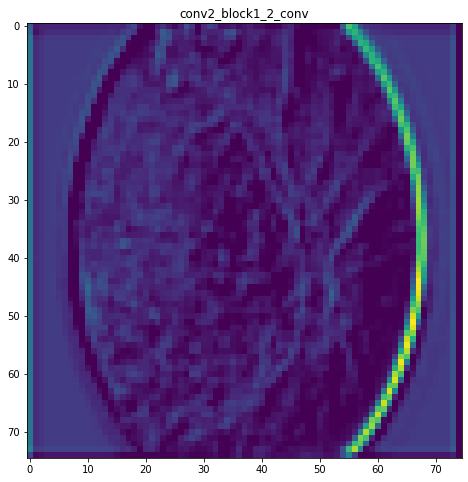

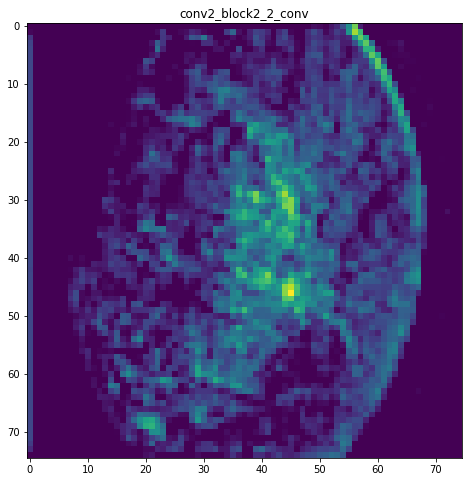

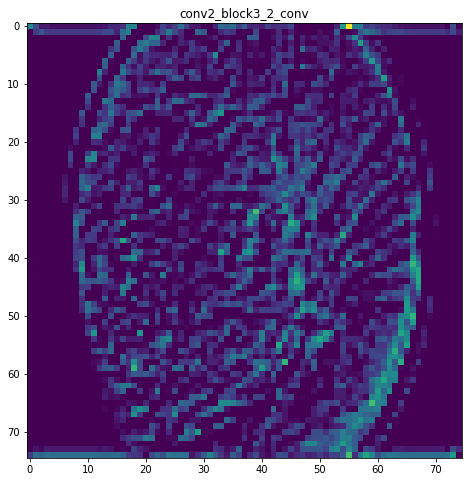

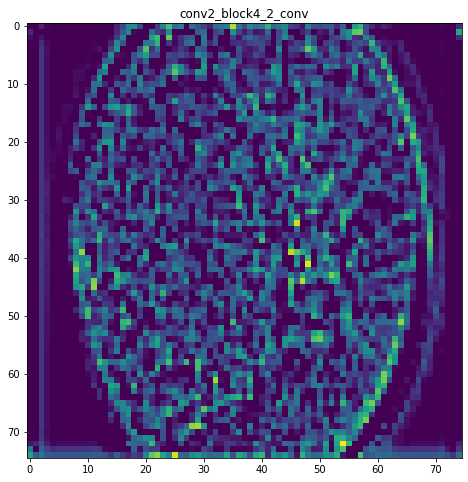

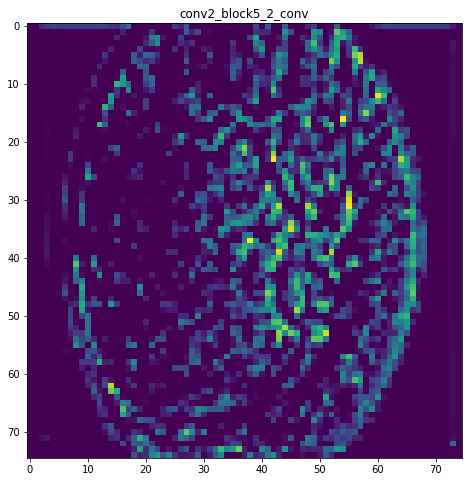

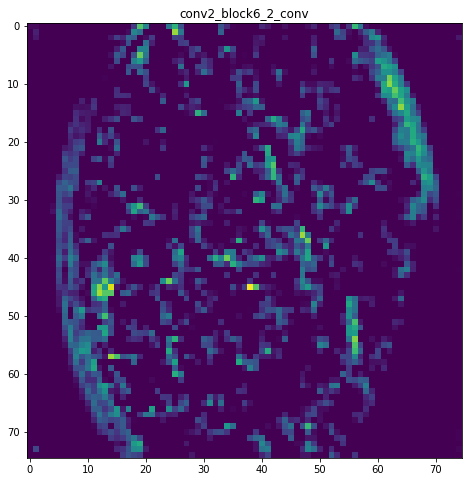

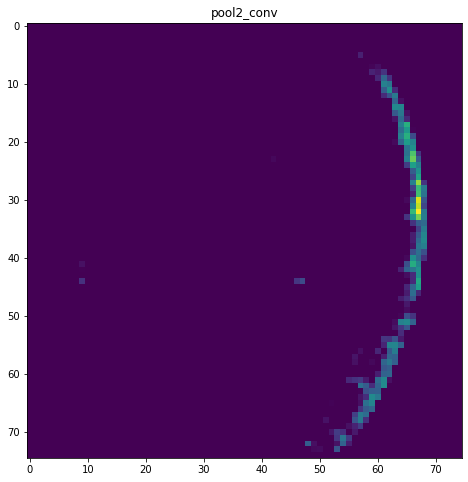

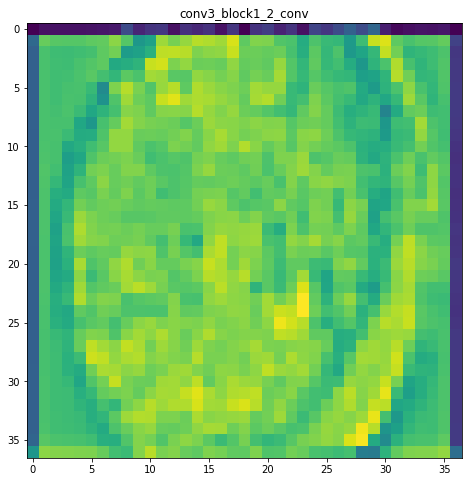

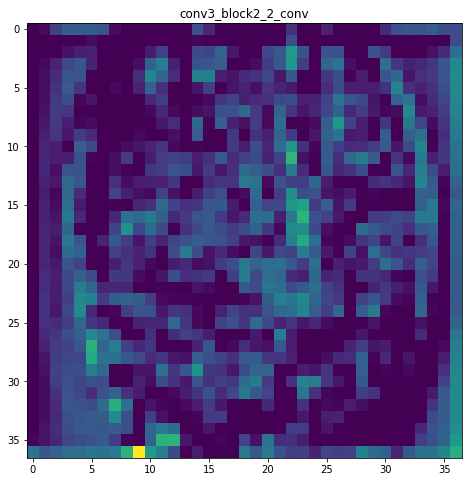

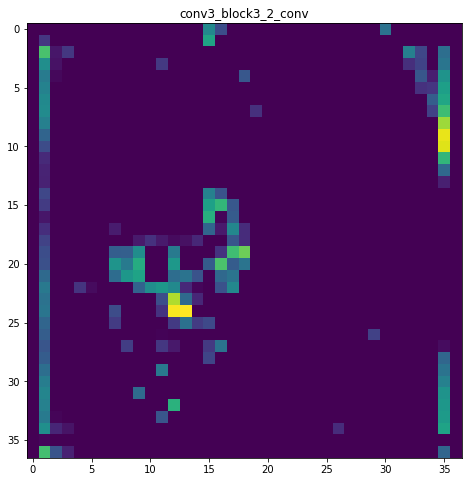

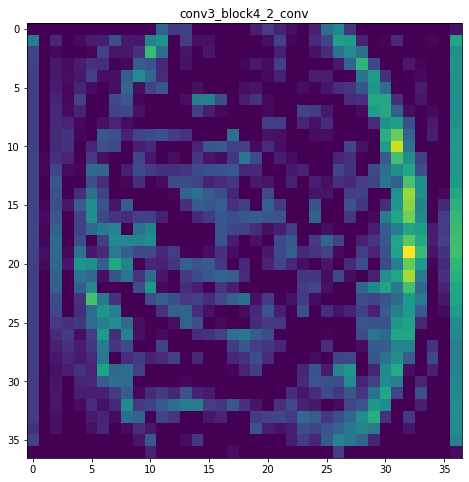

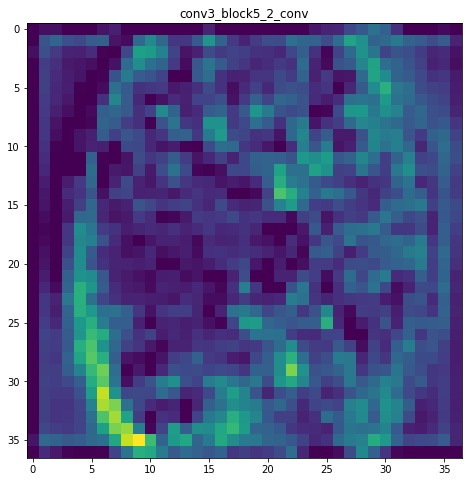

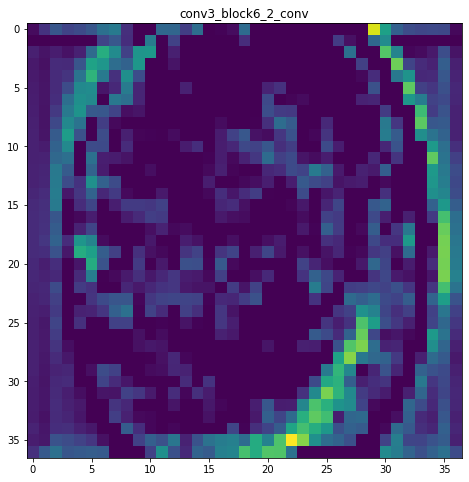

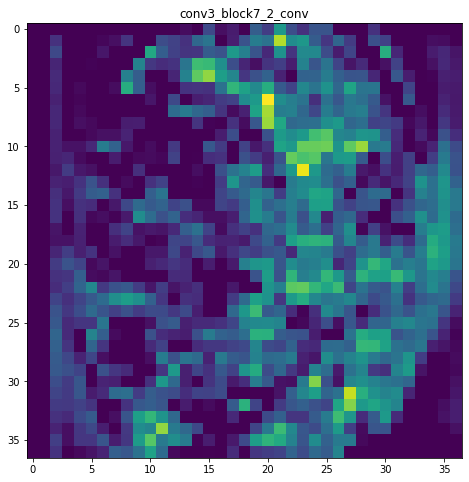

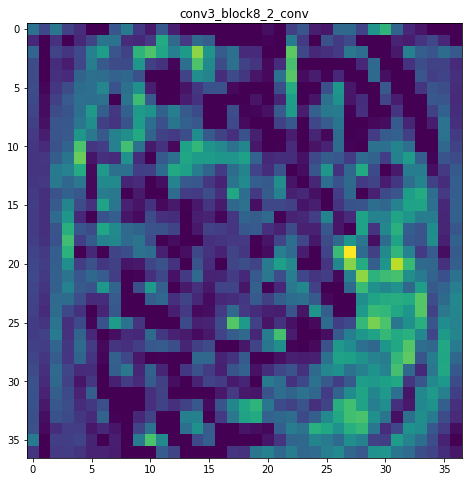

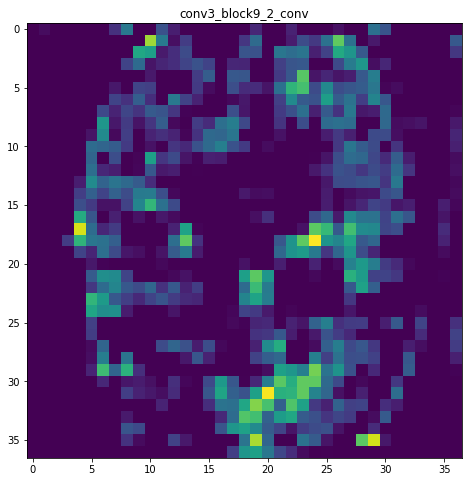

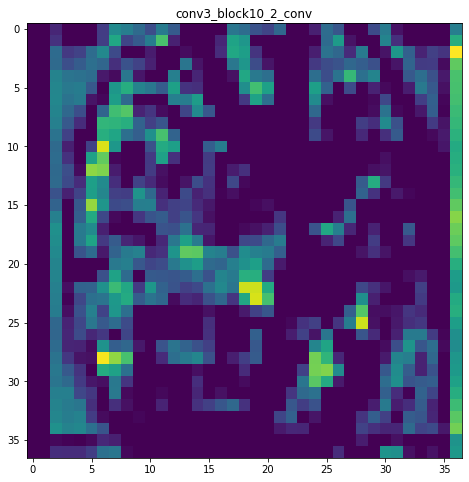

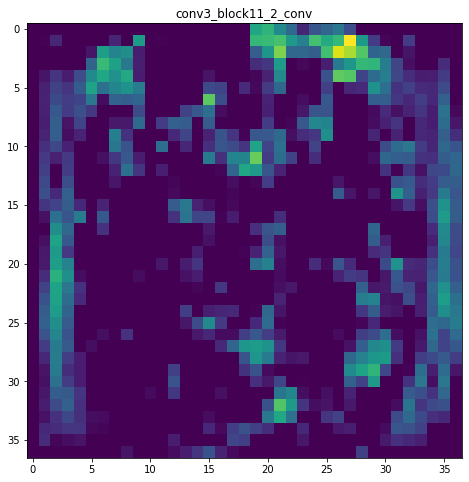

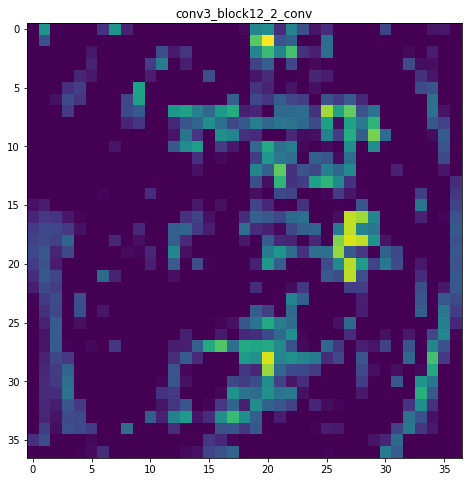

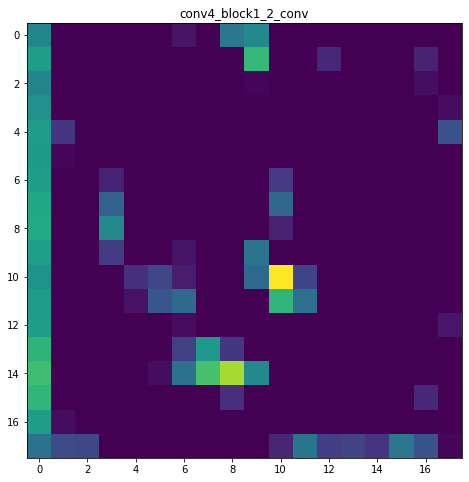

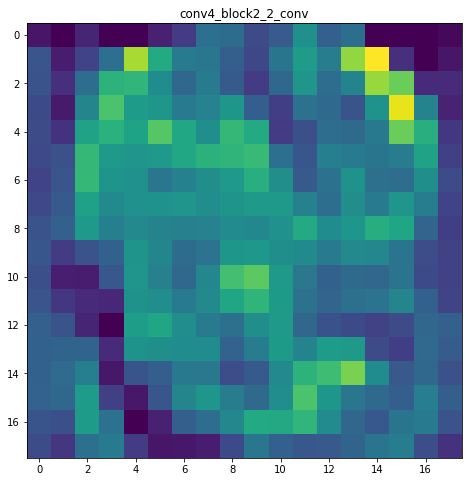

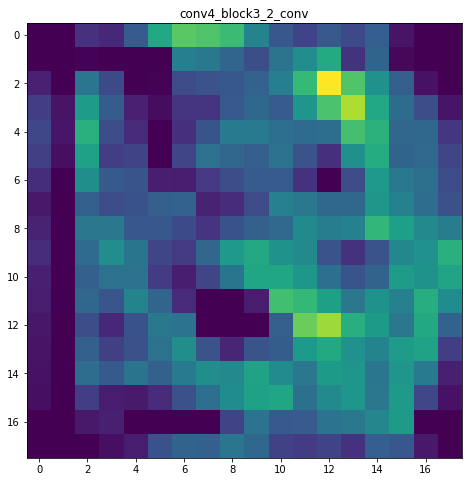

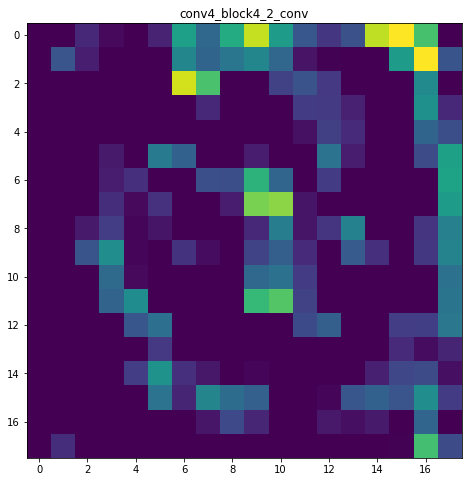

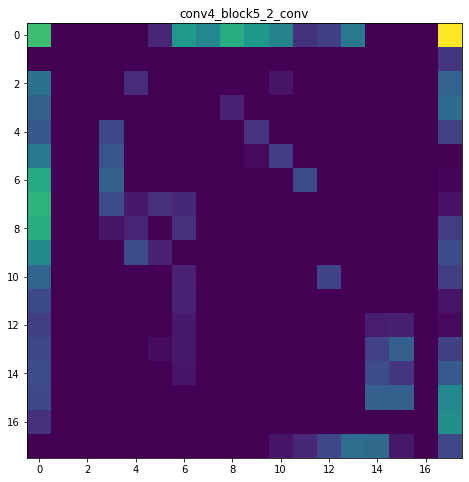

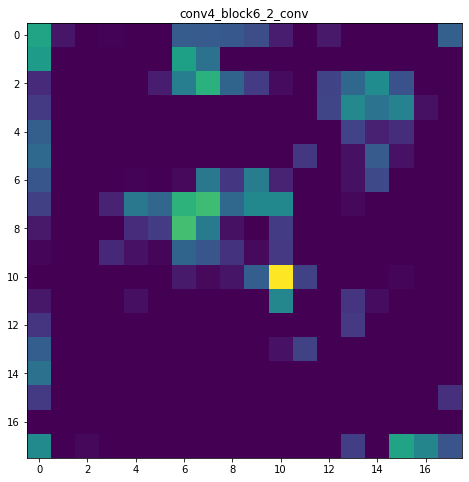

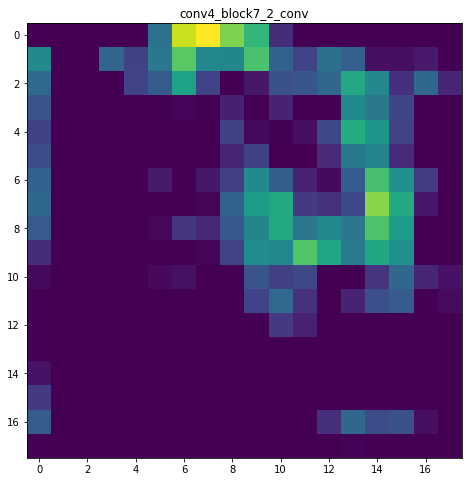

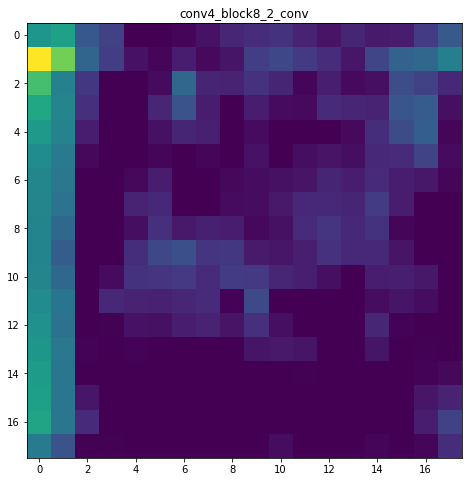

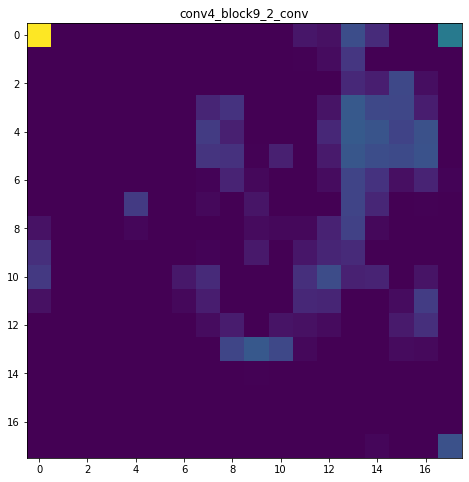

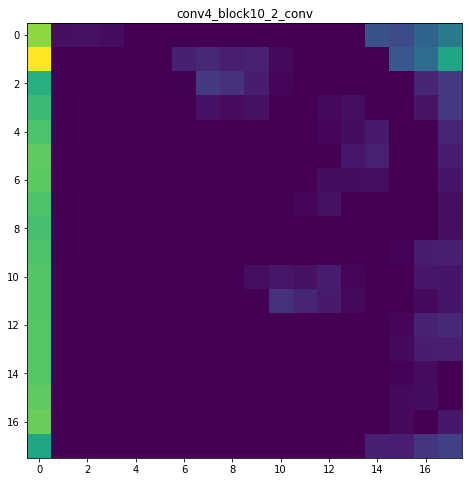

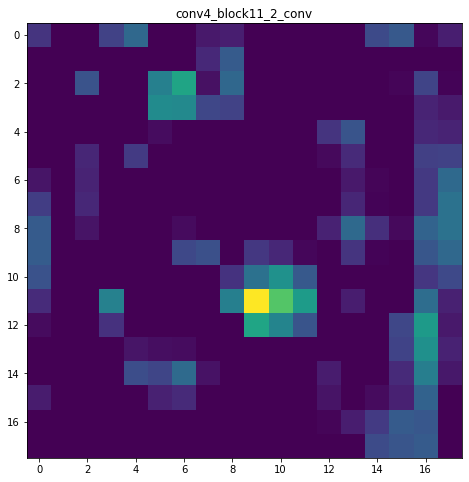

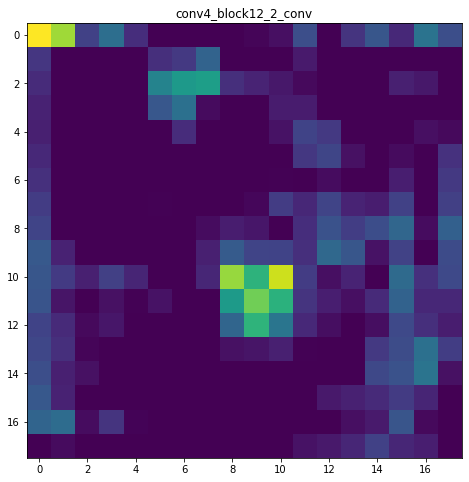

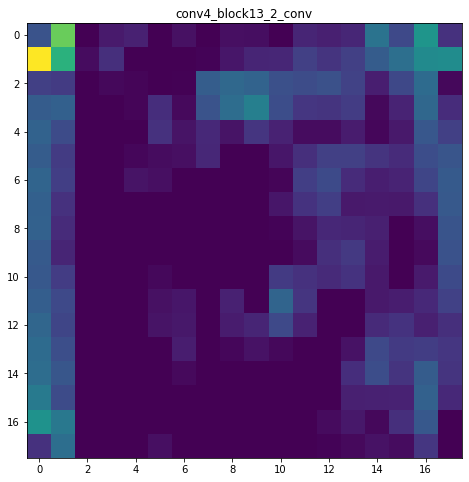

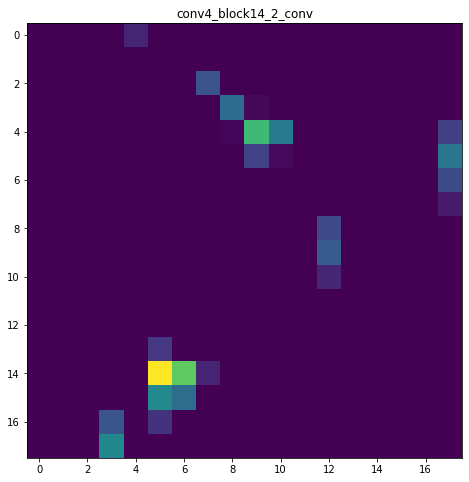

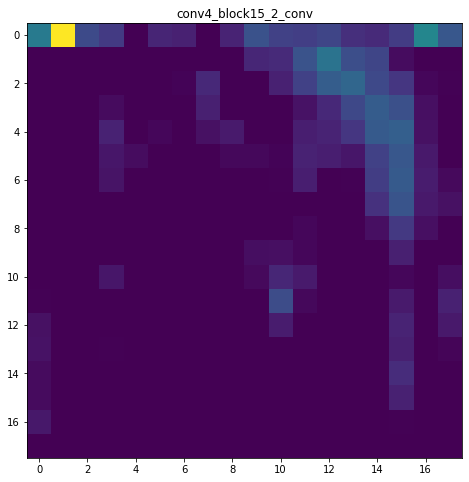

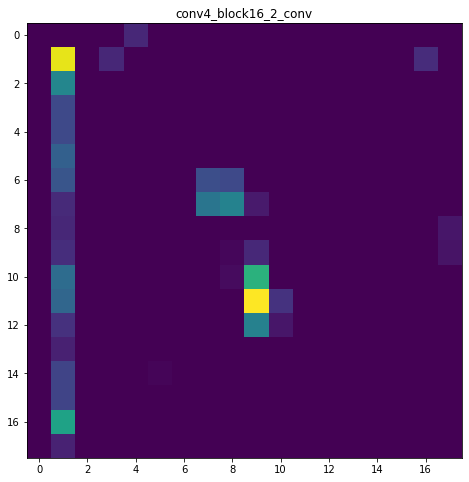

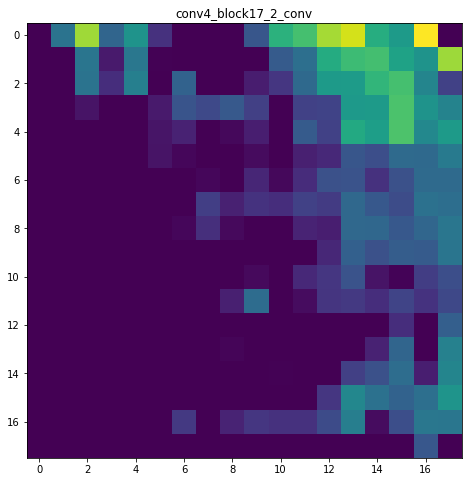

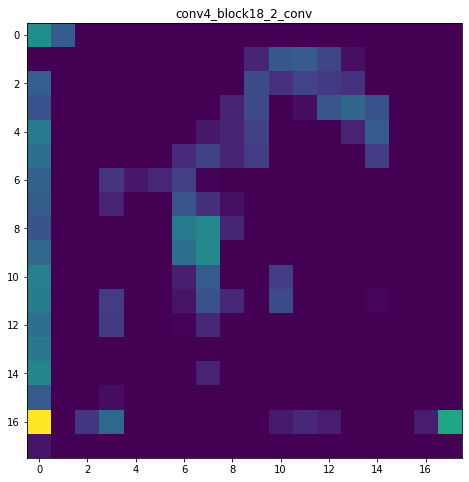

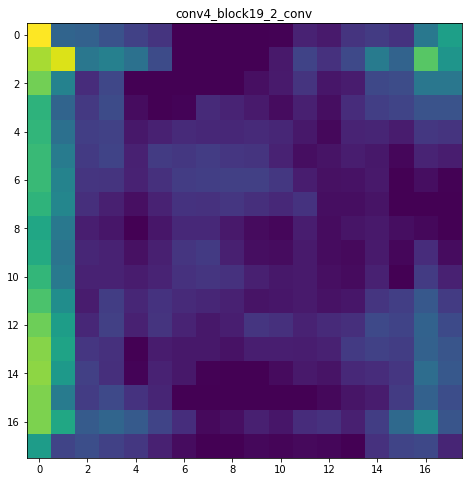

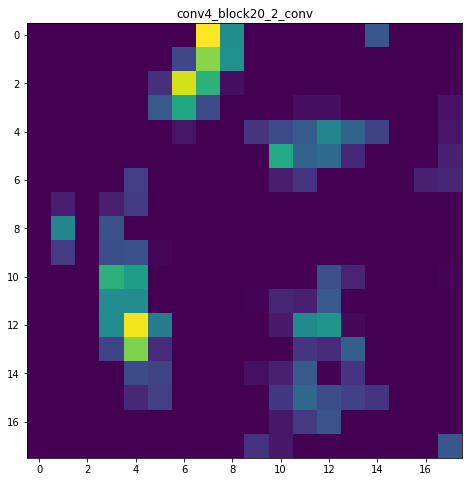

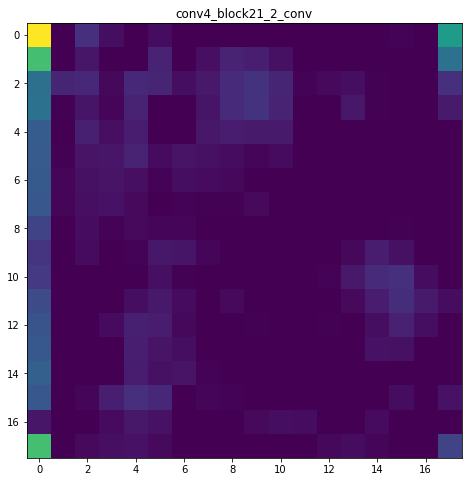

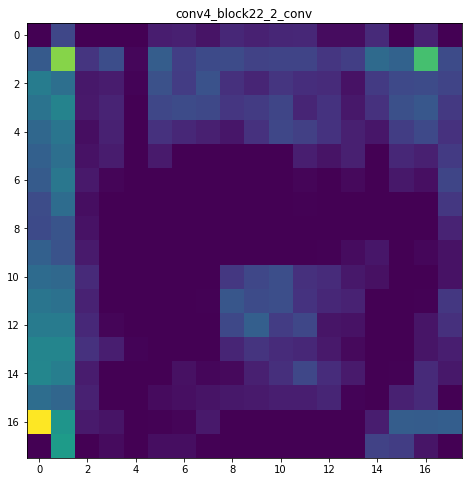

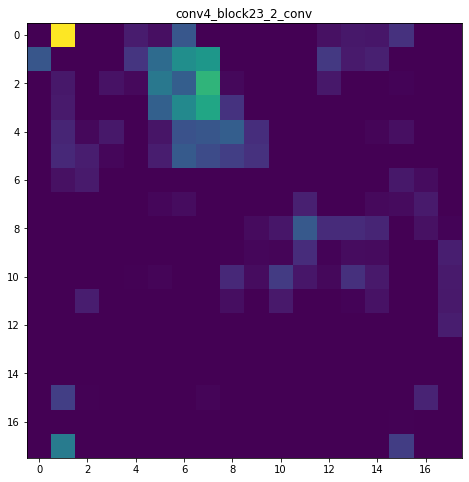

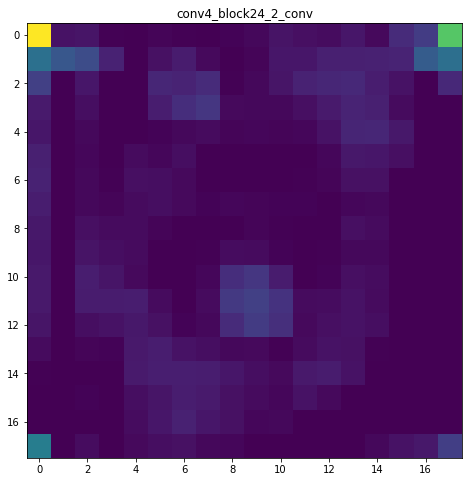

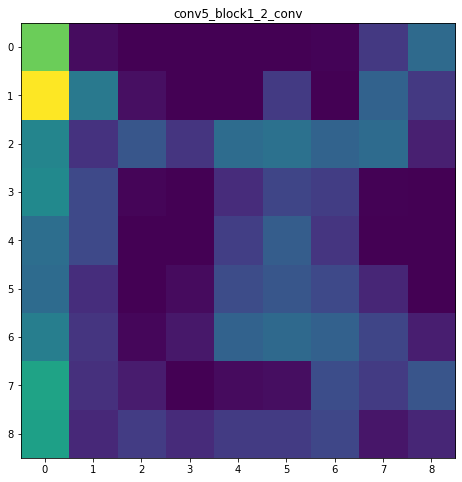

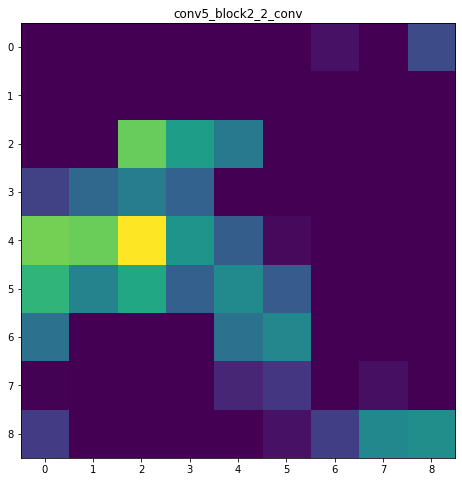

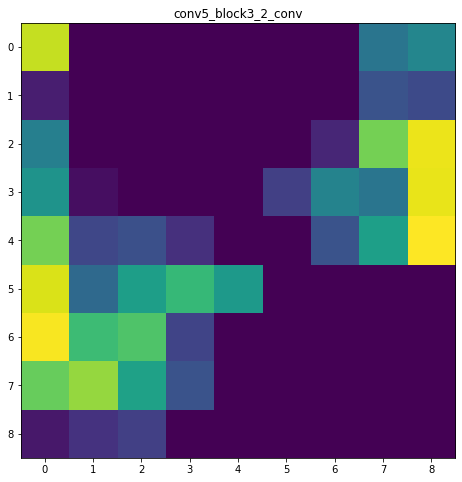

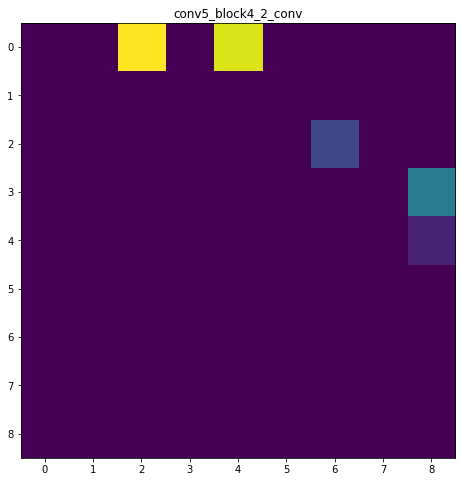

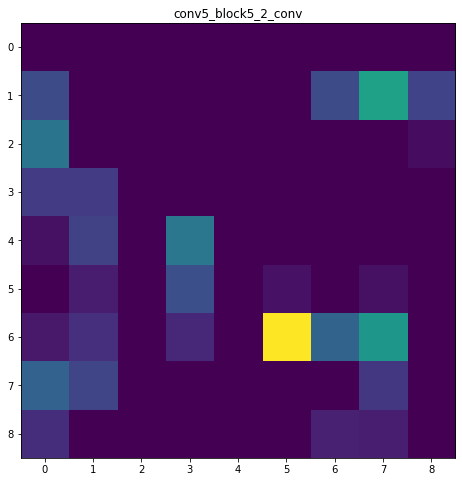

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/site-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


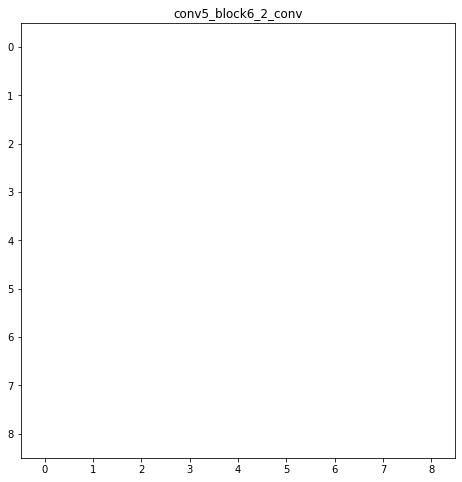

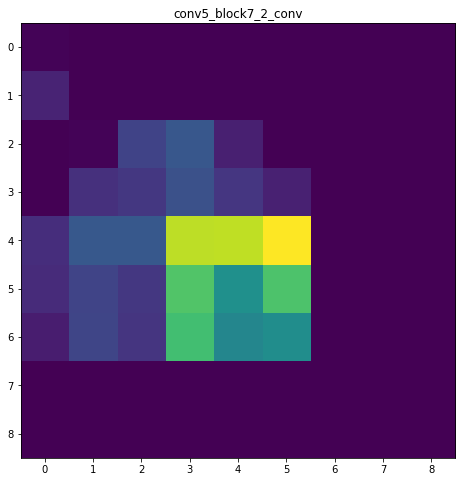

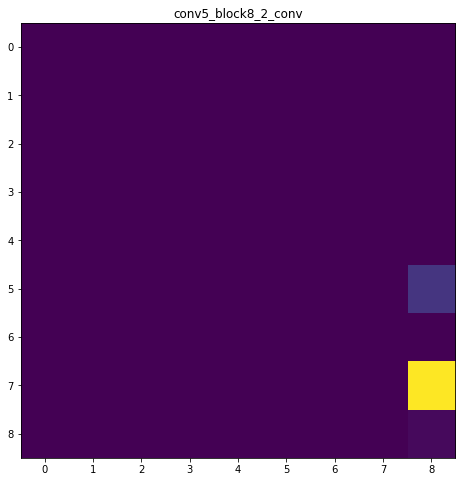

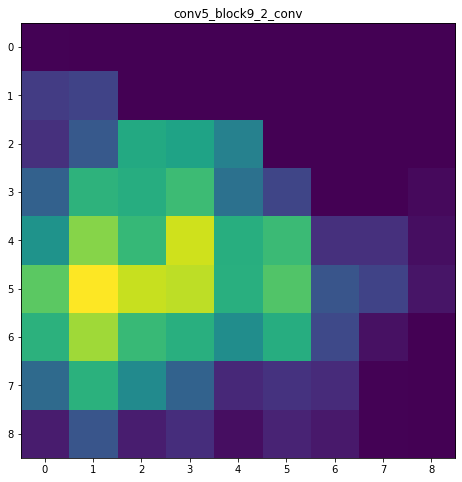

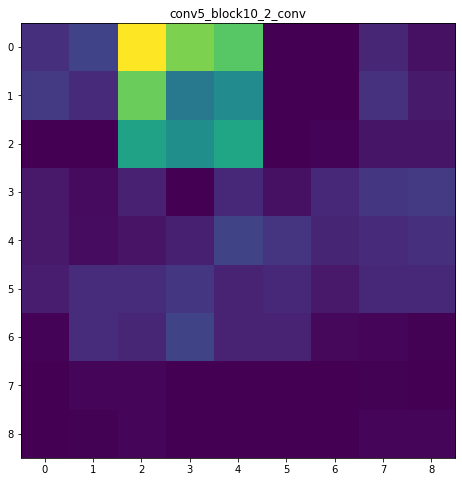

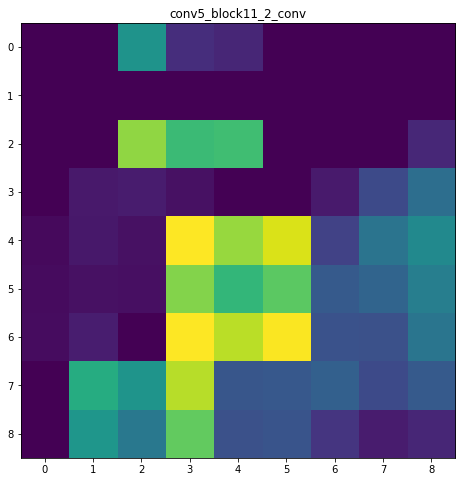

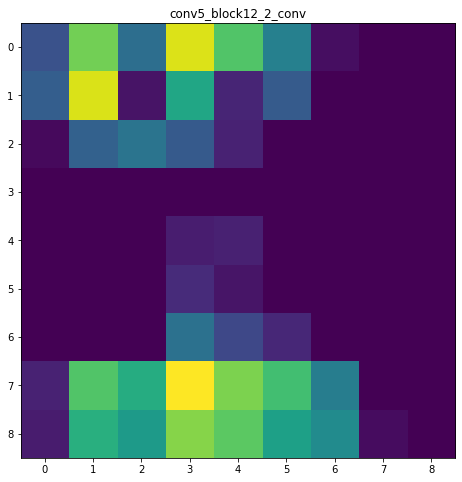

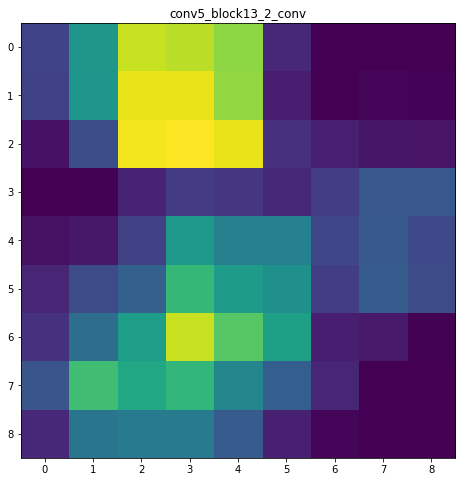

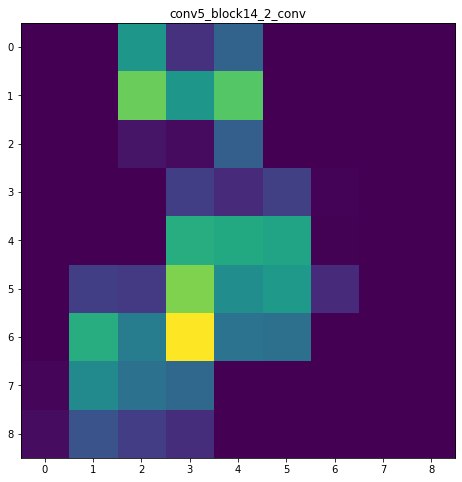

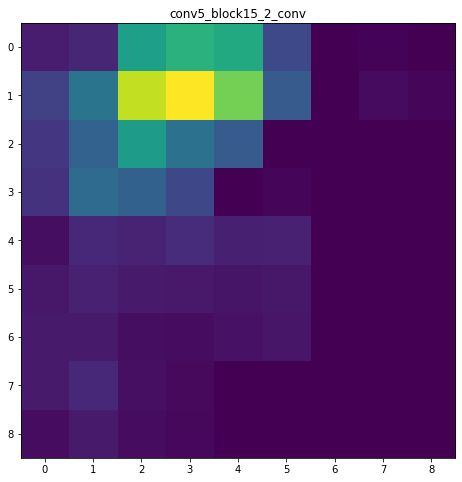

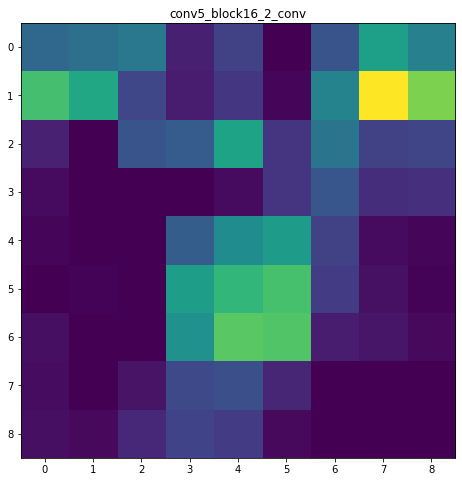

In [25]:
# np.seterr(divide='ignore', invalid='ignore')
for i in range(59):
    plt.figure(figsize=(8,8))
#     plt.subplot(5, 3, i+1)
    img_heatmap = np.maximum(heatmap[i], 0)
    img_heatmap /= np.max(img_heatmap)
    plt.imshow(img_heatmap)
    plt.title(layer_names[i])
    plt.savefig('dense_heatmaps/'+str(i)+'_'+layer_names[i])
    plt.show()

In [27]:
import cv2
# We use cv2 to load the original image
img = cv2.imread(img_path)
for i, hm in enumerate(heatmap):
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    
    # We resize the heatmap to have the same size as the original image
    img_hm = cv2.resize(img_heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    img_hm = np.uint8(255 * img_hm)

    # We apply the heatmap to the original image
    img_hm = cv2.applyColorMap(img_hm, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = img_hm * 0.4 + img

    # Save the image to disk
    cv2.imwrite('dense_imposed_heatmap/{}_{}.jpg'.format(i, layer_names[i]), superimposed_img)
    print ('processing', i)


processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24
processing 25
processing 26
processing 27
processing 28
processing 29
processing 30
processing 31
processing 32
processing 33
processing 34
processing 35
processing 36
processing 37
processing 38
processing 39
processing 40
processing 41
processing 42
processing 43
processing 44
processing 45
processing 46
processing 47


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


processing 48
processing 49
processing 50
processing 51
processing 52
processing 53
processing 54
processing 55
processing 56
processing 57
processing 58


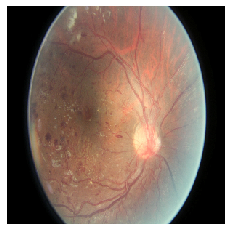

In [28]:
# https://github.com/hovinh/DeCNN/blob/master/experiments.ipynb
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

# image downloaded from: https://www.pexels.com/photo/animal-big-elephant-endangered-133394/
# preprocess the input before feeding into the network
img = image.load_img('sample/16_left.jpeg', target_size=IMG_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img); plt.axis('off'); plt.show()

In [29]:
last_layer_name = 'final_output'

In [30]:
from backprop import Backpropagation
from backprop import SmoothGrad
from backprop import GuidedBackprop
from backprop import DeconvNet
import backprop

backpropagation compute


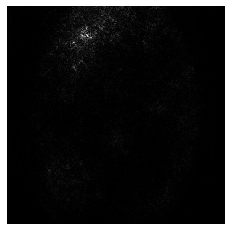

In [31]:
from backprop import Backpropagation

# masking is for selecting which unit to be mapped back
preds = model.predict(x)
masking = np.zeros(preds.shape)
masking[0, np.argmax(preds)] = 1.

bp = Backpropagation(model=model, 
                           layer_name=last_layer_name,
                           input_data=x,
                           masking=masking)
heatmap, _ = bp.compute()
plt.imshow(heatmap[0], cmap='gray'); plt.axis('off'); plt.show()

backpropagation compute
processing 0
processing 10
processing 20
processing 30
processing 40


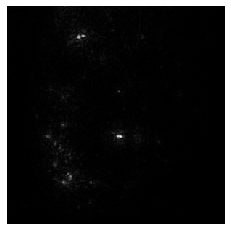

In [32]:
from importlib import reload  
reload(backprop)
from backprop import SmoothGrad

masking = np.zeros(preds.shape)
masking[0, np.argmax(preds)] = 1.

smoothgrad = SmoothGrad(model=model, 
                           layer_name=last_layer_name,
                           input_data=x,
                           masking=masking)
heatmap  = smoothgrad.compute()
plt.imshow(heatmap[0], cmap='gray'); plt.axis('off'); plt.show()

working4
431
feed_forward done
compute
range(430, -1, -1)
layer_idx: 430
layer_idx: 429
layer_idx: 428
layer_idx: 427
layer_idx: 426
layer_idx: 425
layer_idx: 424
layer_idx: 423
layer_idx: 422
layer_idx: 421
layer_idx: 420
layer_idx: 419
layer_idx: 418
layer_idx: 417
layer_idx: 416
layer_idx: 415
layer_idx: 414
layer_idx: 413
layer_idx: 412
layer_idx: 411
layer_idx: 410
layer_idx: 409
layer_idx: 408
layer_idx: 407
layer_idx: 406
layer_idx: 405
layer_idx: 404
layer_idx: 403
layer_idx: 402
layer_idx: 401
layer_idx: 400
layer_idx: 399
layer_idx: 398
layer_idx: 397
layer_idx: 396
layer_idx: 395
layer_idx: 394
layer_idx: 393
layer_idx: 392
layer_idx: 391
layer_idx: 390
layer_idx: 389
layer_idx: 388
layer_idx: 387
layer_idx: 386
layer_idx: 385
layer_idx: 384
layer_idx: 383
layer_idx: 382
layer_idx: 381
layer_idx: 380
layer_idx: 379
layer_idx: 378
layer_idx: 377
layer_idx: 376
layer_idx: 375
layer_idx: 374
layer_idx: 373
layer_idx: 372
layer_idx: 371
layer_idx: 370
layer_idx: 369
layer_idx: 3

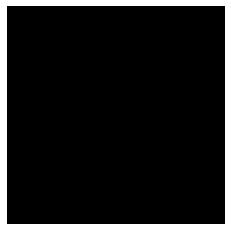

In [17]:
from importlib import reload  
reload(backprop)
import backprop
from backprop import GuidedBackprop

masking = np.zeros(preds.shape)
masking[0, np.argmax(preds)] = 1.

guidedbackprop = GuidedBackprop(model=model, 
                           layer_name=last_layer_name,
                           input_data=x,
                           masking=masking)
heatmap  = guidedbackprop.compute()
plt.imshow(heatmap[0], cmap='gray'); plt.axis('off'); plt.show()

# GuidedBackprop??

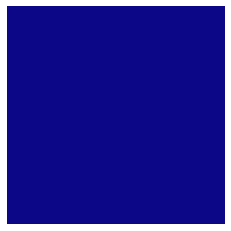

In [22]:
heatmap_guided = heatmap
plt.imshow(heatmap[0], cmap='plasma'); plt.axis('off'); plt.show()

DeconvNet compute range(430, -1, -1)
layer_idx: 430
layer_idx: 429
layer_idx: 428
layer_idx: 427
layer_idx: 426
layer_idx: 425
layer_idx: 424
layer_idx: 423
layer_idx: 422
layer_idx: 421
layer_idx: 420
layer_idx: 419
layer_idx: 418
layer_idx: 417
layer_idx: 416
layer_idx: 415
layer_idx: 414
layer_idx: 413
layer_idx: 412
layer_idx: 411
layer_idx: 410
layer_idx: 409
layer_idx: 408
layer_idx: 407
layer_idx: 406
layer_idx: 405
layer_idx: 404
layer_idx: 403
layer_idx: 402
layer_idx: 401
layer_idx: 400
layer_idx: 399
layer_idx: 398
layer_idx: 397
layer_idx: 396
layer_idx: 395
layer_idx: 394
layer_idx: 393
layer_idx: 392
layer_idx: 391
layer_idx: 390
layer_idx: 389
layer_idx: 388
layer_idx: 387
layer_idx: 386
layer_idx: 385
layer_idx: 384
layer_idx: 383
layer_idx: 382
layer_idx: 381
layer_idx: 380
layer_idx: 379
layer_idx: 378
layer_idx: 377
layer_idx: 376
layer_idx: 375
layer_idx: 374
layer_idx: 373
layer_idx: 372
layer_idx: 371
layer_idx: 370
layer_idx: 369
layer_idx: 368
layer_idx: 367
lay

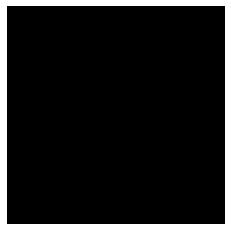

In [21]:
from importlib import reload  
reload(backprop)
import backprop
from backprop import DeconvNet

masking = np.zeros(preds.shape)
masking[0, np.argmax(preds)] = 1.

deconvnet = DeconvNet(model=model, 
                           layer_name=last_layer_name,
                           input_data=x,
                           masking=masking)
heatmap_deconvnet  = deconvnet.compute()
plt.imshow(heatmap_deconvnet[0], cmap='gray'); plt.axis('off'); plt.show()

In [50]:
from importlib import reload  
reload(vis)
from vis.losses import ActivationMaximization
from vis.regularizers import TotalVariation, LPNorm
# from vis.modifiers import Jitter
from vis.input_modifiers import Jitter
from vis.optimizer import Optimizer

from vis.callbacks import GifGenerator

layer_name = 'final_output'
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
output_class = [20]

losses = [
    (ActivationMaximization(layer_dict[layer_name], output_class), 2),
    (LPNorm(model.input), 10),
    (TotalVariation(model.input), 10)
]
opt = Optimizer(model.input, losses)
opt.minimize(max_iter=500, verbose=True, image_modifiers=[Jitter()], callbacks=[GifGenerator('opt_progress')])


ValueError: slice index 20 of dimension 1 out of bounds. for 'strided_slice_79' (op: 'StridedSlice') with input shapes: [?,5], [2], [2], [2] and with computed input tensors: input[1] = <0 20>, input[2] = <0 21>, input[3] = <1 1>.

In [55]:
# from keras.applications import VGG16
from vis.utils import utils
from keras import activations

# Build the VGG16 network with ImageNet weights
# model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'final_output')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

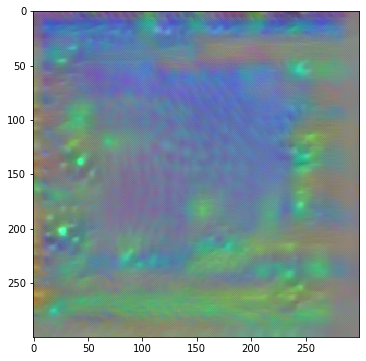

In [57]:
from vis.visualization import visualize_activation

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# 20 is the imagenet category for 'ouzel'
img = visualize_activation(model, layer_idx, filter_indices=4)
plt.imshow(img)

In [ ]:
from vis.visualization import visualize_activation

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# 20 is the imagenet category for 'ouzel'
img = visualize_activation(model, layer_idx, filter_indices=4)
plt.imshow(img)

In [22]:
from vis.utils import utils
from keras import activations

# Build the VGG16 network with ImageNet weights

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'final_output')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

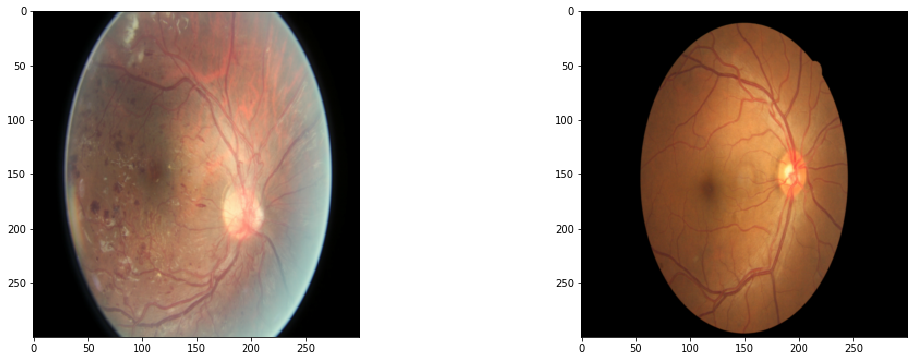

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('sample/16_left.jpeg', target_size=IMG_SIZE)
img2 = utils.load_img('sample/17_right.jpeg', target_size=IMG_SIZE)

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

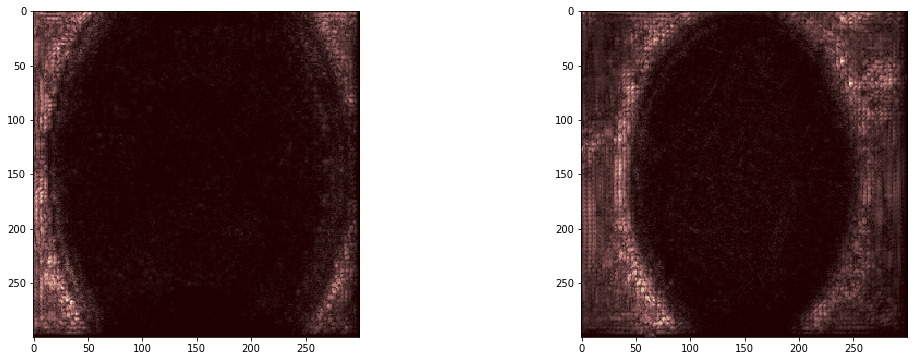

In [24]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'final_output')

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=2, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='pink')

guided
2.1.0
relu


<Figure size 1296x432 with 0 Axes>

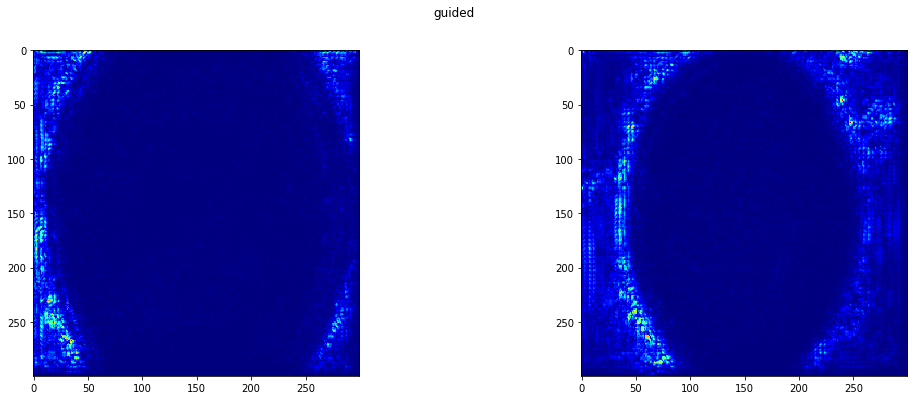

<Figure size 1296x432 with 0 Axes>

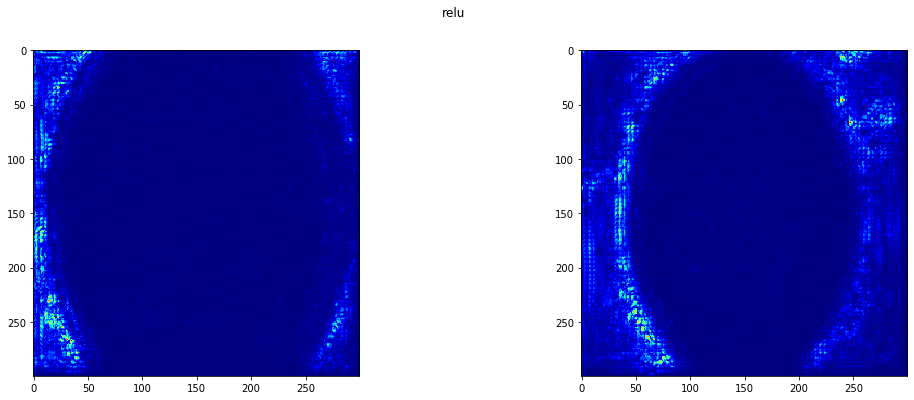

In [7]:
# from importlib import reload  
# reload(vis)
# reload(vis.visualization)
# reload(vis.visualization)
# reload(vis.visualization)
# import vis
from vis.visualization import visualize_saliency, overlay
for modifier in ['guided', 'relu']:
    print (modifier)
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_saliency(model, layer_idx, filter_indices=2, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')

None
guided
relu


<Figure size 1296x432 with 0 Axes>

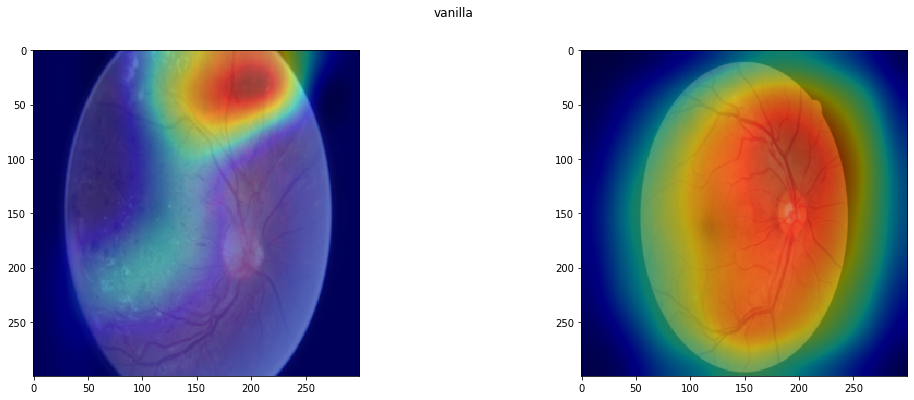

<Figure size 1296x432 with 0 Axes>

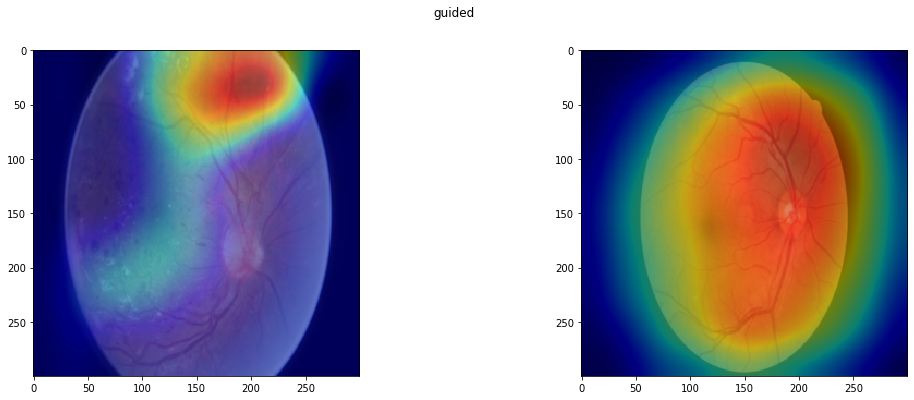

<Figure size 1296x432 with 0 Axes>

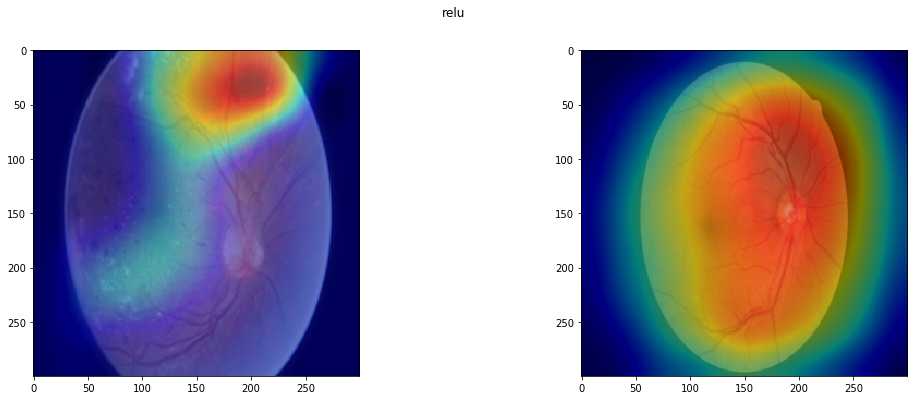

In [8]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    print (modifier)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=2, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

<Figure size 1296x432 with 0 Axes>

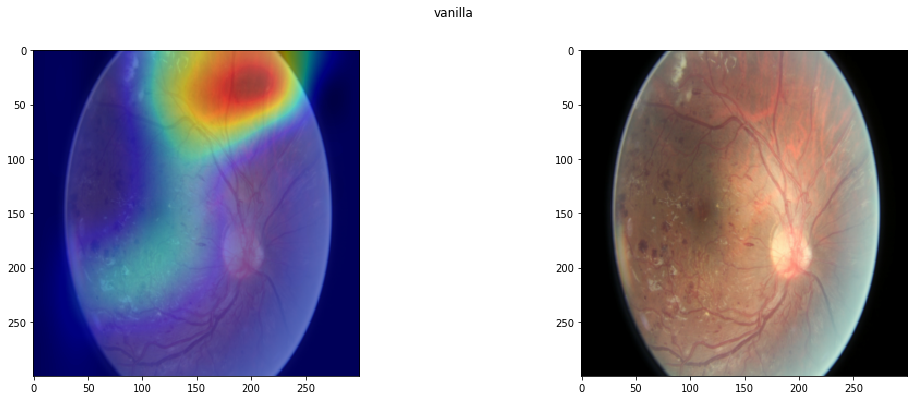

In [26]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None]:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_cam(model, layer_idx, filter_indices=2, 
                          seed_input=img1, backprop_modifier=modifier)        
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    ax[0].imshow(overlay(jet_heatmap, img1))
    ax[1].imshow(img1)